## Data preprocessing
This file includes the loading of the data (videos), the sampling to extract dataframes as images
and subsequent preprocessing to extract additional features

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import dlib
import numpy as np
import os
import shutil


In [2]:
DATA_PATH = "data"
VIDEOS_PATH = DATA_PATH+"/videos"
IMAGES_PATH = DATA_PATH+"/images"
FEATURES_PATH = DATA_PATH+"/features"
labels = ['alert', 'slight_drowsy','mod_drowsy','very_drowsy'] # alert, slightly drowsy, moderately drowsy and very drowsy

In [4]:
# Create a VideoCapture object and open the video file
cap = cv2.VideoCapture(VIDEOS_PATH+'/alert/alert_1.mp4')

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Print the total number of frames and fps
print(f'Total frames: {total_frames}')
print(f'Frames per second: {fps}')


Total frames: 7923
Frames per second: 30


### Creating a generator to return the frames of a video as a numpy array

In [5]:
def video_frame_generator(cap):

  # Loop through each frame in the video
  while True:
      # Read the frame from the video
      ret, frame = cap.read()

      # Break the loop if the end of the video is reached
      if not ret:
          break
      
      # Convert the frame to RGB
      # Mediapipe Face Detection model (used later on)
      # was trained on RGB images not BGR
      rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
      yield np.array(rgb_image)

### Extracting 1800 frames at a time due to memory issues
Trying first with one of the 'alert' videos

In [6]:
def generate_images_array(cap, video_path, IMAGES_PATH, total_frames, start_frame=0, frames_sample=1800):
    """
    Function to extract frames from a video and save them as a NumPy array.

    * Input:
    - video_path: string representing the path to the video file
    - start_frame: integer representing the frame number to start from (default=0)
    - frames_sample: integer representing the number of frames to sample (default=1800)

    * Output:
    A numpy array with the image data.
    """

    generator = video_frame_generator(cap)

    # Extract the frames from the video
    image_data = []

    frame_num = 0
    # Extracting the frames_sample (1800 frames)
    for img in generator:
        if frame_num < frames_sample + start_frame and frame_num >= start_frame:
            image_data.append(img)
        frame_num += 1
        if frame_num >= total_frames:
            break

    # Save the image_data list as a NumPy array
    # np.save(IMAGES_PATH+'/normal'+video_path+'.npy', np.array(image_data))

    # Return the image data as a NumPy array
    return np.array(image_data)

In [9]:
img_alert_1 = generate_images_array(cap, '/alert/alert_1', IMAGES_PATH, total_frames)

In [10]:
# Loading the numpy array
# img_alert_1 = np.load(IMAGES_PATH+'/alert/alert_1.npy')
print(img_alert_1.shape)
# Shape means:
# -> 1800 images
# -> 720 pixels height
# -> 1280 pixels width
# -> 3 channels (RGB)

(1800, 720, 1280, 3)


### Displaying the extracted images and applying transformations to optimize brightness levels

In [11]:
# Original images:
# Loop through each image and display it
for image in img_alert_1:
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Need to transform to BGR for cv2
    cv2.imshow('Image', img)
    key = cv2.waitKey(0) # press any key for next image
    if key == 27: # press ESC to stop
        break

cv2.destroyAllWindows()

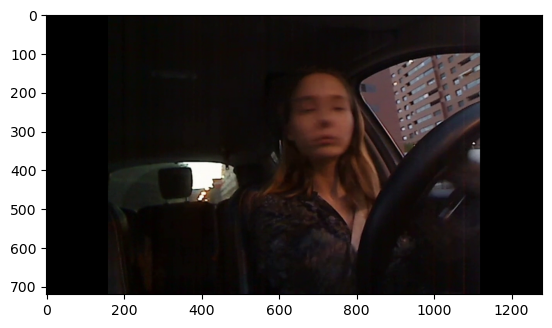

In [20]:
# Example of an image blinking
plt.imshow(img_alert_1[28])
plt.show()

#### Transformation performed:
1. Convert the input image from RGB color space to the LAB color space using ***'cv2.cvtColor(image, cv2.COLOR_RGB2LAB)'***. The LAB color space separates the image into three channels: L for luminance, A for the green-red color channel, and B for the blue-yellow color channel.
2. Split the LAB image into its three channels using ***'cv2.split(lab)'***. This separates the image into three separate 2D NumPy arrays representing the L, A, and B channels.
3. Apply *Contrast Limited Adaptive Histogram Equalization* (CLAHE) to the L channel of the LAB image using ***'cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))'*** and ***'clahe.apply(l)'***. CLAHE enhances the contrast of the image by normalizing the pixel intensities locally in small regions of the image, <u>**improving the visibility of details in both bright and dark regions**</u>.
4. Merge the three channels back together using ***'cv2.merge((l_eq, a, b))'***, creating a new LAB image.
5. Convert the LAB image to the BGR color space using ***'cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)'*** for cv2 display.

In [7]:
def transform_image(image, channels):
    """
    Function that performs tranformations on the image to
    improve luminance.
    
    * Input:
    - image: image in RGB colorscale
    - channels: channels for the output image ('rgb' or 'bgr')

    * Ouput:
    - brightened_img: brightened image colorspace provided (rgb or bgr)
    """
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    # split the channels
    l, a, b = cv2.split(lab)
    # apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    l_eq = clahe.apply(l)
    # merge the channels back together
    lab_eq = cv2.merge((l_eq, a, b))

    # convert back to RGB or BGR color space
    if channels=='rgb':
        brightened_img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)
    else:
        brightened_img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    return brightened_img

In [13]:
# Transformed images:
# Loop through each image and display it
for image in img_alert_1:
    # call transformation function
    brightened_img = transform_image(image,'bgr')
    cv2.imshow('Image', brightened_img)
    key = cv2.waitKey(0) # press any key for next image
    if key == 27: # press ESC to stop
        break

cv2.destroyAllWindows()

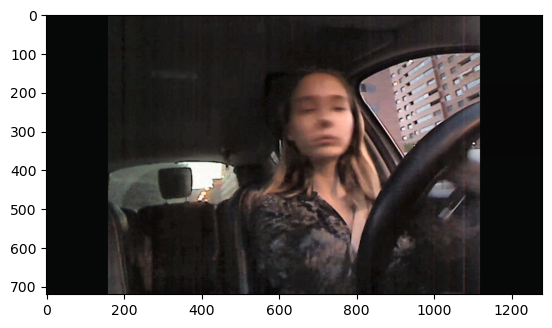

In [23]:
# Example of an image blinking
input_image=img_alert_1[28]

brightened_img = transform_image(input_image,'rgb')

plt.imshow(brightened_img)
plt.show()

### Facial landmarks detection
There are two common libraries 'dlib' and 'mediapipe'. Will try both to and then choose one for the rest of the project.

#### Mediapipe facial landmarks

In [8]:
def initialize_mediapipe_models():
    """
    Function that initializes the classes for the Mediapipe face detection and landmark models 
    and returns them as outputs.
    
    * Output:
    - mp_face_detection: class for the face detection model
    - mp_face_mesh: class for the face landmark model
    """
    
    mp_face_detection = mp.solutions.face_detection
    mp_face_mesh = mp.solutions.face_mesh

    return mp_face_detection, mp_face_mesh

In [9]:
def cv2Display_mediapipe(image, bright, mp_face_detection, mp_face_mesh):
    """
    Function that displays on screen the image with its facial landmarks
    from the mediapipe model and the face detected surrounded by a square.

    * Input:
    - image: image to be displayed (RGB)
    - bright: boolean variable, True if want to perform transformation to brighten image
    - mp_face_detection: class of the mediapipe FaceDetection model
    - mp_face_mesh: class of the mediapipe FaceMesh model

    * Output:
    The function doesn't return any variable, but displays on screen the image
    """

    # Initialize the models
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)
    face_mesh = mp_face_mesh.FaceMesh()

    # Brighten image if wanted
    # input image in RGB because mediapipe was trained with RGB images, not BGR
    if bright==True:
        # new input image brightened
        input_image = transform_image(image,'rgb')
    else:
        input_image = image.copy()

    # create a copy of the input image
    output_image = input_image.copy()
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

    # Detect faces in the input image
    results = face_detection.process(input_image)

    try:
        # If a face is detected, extract the face bounding box and landmarks
        for detection in results.detections:
            # Extract the face bounding box coordinates
            bbox = detection.location_data.relative_bounding_box
            h, w, c = input_image.shape
            bbox = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)
            # Draw the face bounding box (green, 2=thickness)
            cv2.rectangle(output_image, bbox, (0, 255, 0), 2)
            # Extract facial landmarks
            face_pts = face_mesh.process(input_image).multi_face_landmarks[0]
            for pt in face_pts.landmark:
                # Convert normalized landmark coordinates to pixel coordinates
                x, y = int(pt.x * w), int(pt.y * h) # center coordinates of the circle to be drawn
                # Draw facial landmarks
                cv2.circle(output_image, (x, y), 2, (255, 0, 0), -1) # -1=thickness (filled), 2=radius
    except:
        # If face detection and landmark extraction fails, move to the next frame
        pass

    # Display the image with face bounding boxes and landmarks
    cv2.imshow('mediapipe', output_image)

    # Reset face mesh model
    face_mesh.close()

In [16]:
# Load input image
image = img_alert_1[28]

mp_face_detection, mp_face_mesh = initialize_mediapipe_models()

# With the original image
cv2Display_mediapipe(image, False, mp_face_detection, mp_face_mesh)
cv2.waitKey(0)
cv2.destroyAllWindows()

# With the brightened image
cv2Display_mediapipe(image, True, mp_face_detection, mp_face_mesh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
# Loop through all images and display them
for image in img_alert_1:
    cv2Display_mediapipe(image, True, mp_face_detection, mp_face_mesh)
    key = cv2.waitKey(0)
    if key == 27:
        break

cv2.destroyAllWindows()

#### Dlib facial landmarks

In [19]:
def initialize_dlib_models():
    """
    Function that initializes the dlib face detector and facial landmark predictor models.
    
    * Output:
    - detector: dlib face detector model
    - predictor: dlib facial landmark predictor model
    """
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')

    return detector, predictor

In [20]:
def cv2Display_dlib(image, bright, detector, predictor):
    """
    Function that displays on screen the image with its facial landmarks
    and the face detected surrounded by a square.

    * Input:
    - image: image to be displayed (RGB)
    - bright: boolean variable, True if want to perform transformation to brighten image
    - detector: dlib face detector model
    - predictor: dlib facial landmark predictor model

    * Output:
    The function doesn't return any variable, but displays on screen the image
    """

    # Brighten image if wanted
    # input image in RGB because mediapipe was trained with RGB images, not BGR
    if bright==True:
        # new input image brightened
        input_image = transform_image(image,'rgb')
    else:
        input_image = image.copy()

    # create a copy of the input image
    output_image = input_image.copy()
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

    # detect faces in input image
    detections = detector(input_image)

    # loop over face detections
    for detection in detections:
        # get facial landmarks for current face detection
        landmarks = predictor(input_image, detection)

        # draw face bounding box
        x, y, w, h = detection.left(), detection.top(), detection.right()-detection.left(), detection.bottom()-detection.top()
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # draw facial landmarks
        for i in range(68):
            x, y = landmarks.part(i).x, landmarks.part(i).y
            cv2.circle(output_image, (x, y), 2, (0, 0, 255), -1)

    # display the image with face bounding boxes and landmarks
    cv2.imshow('dlib', output_image)

In [21]:
# Load input image
image = img_alert_1[28]

detector, predictor = initialize_dlib_models()

# With the original image
cv2Display_dlib(image, False, detector, predictor)
cv2.waitKey(0)
cv2.destroyAllWindows()

# With the brightened image
cv2Display_dlib(image, True, detector, predictor)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# Loop through all images and display them
for image in img_alert_1:
    cv2Display_dlib(image, True, detector, predictor)
    key = cv2.waitKey(0)
    if key == 27:
        break

cv2.destroyAllWindows()

# When the head turns too much the dlib model fails to detect a face
# as the model is for frontal face only while mediapipe still works.
# Therefore, mediapipe seems like a more appropiate model to use.

### Extracting additional features: EAR (eye aspect ratio), MAR (mouth aspect ratio), blink frequency, blink duration.

In [10]:
def calculate_aspect_ratio(landmarks):
    """
    Function that calculates the aspect ratio for a given set of landmarks.
    We will use it for EAR and MAR

    * Input:
    - landmarks: list of tuples containing the (x, y, z) coordinates of facial landmarks

    * Output:
    The aspect ratio (AR) calculated for the given landmarks.
    """
    # Extract coordinates of landmarks
    coordinates = [(lmk.x, lmk.y, lmk.z) for lmk in landmarks]

    # Compute Euclidean distances between the sets of landmarks
    width = np.linalg.norm(np.array(coordinates[0]) - np.array(coordinates[3]))
    height_1 = np.linalg.norm(np.array(coordinates[1]) - np.array(coordinates[5]))
    height_2 = np.linalg.norm(np.array(coordinates[2]) - np.array(coordinates[4]))

    # Calculate aspect ratio (AR)
    ar = (height_1 + height_2) / (2 * width)
    return ar

#### EAR and blink detection:
First, trying with a specific blink image to adjust the threshold and then, doing it for all images.
Blink detection will then be used to get the blink duration and frequency.
Information will be stored in a pandas DataFrame.

In [11]:
def get_EAR(input_image, mp_face_mesh):
    """
    Function that gets the eye aspect ratio (EAR) for the left and right eye of a person in a given image.

    * Input:
    - input_image: the input image (RGB)
    - mp_face_mesh: class of the mediapipe FaceMesh model
    
    * Output:
    - A tuple containing the EAR for the left eye and right eye, respectively.
    """
    
    # Initialize face mesh model
    face_mesh = mp_face_mesh.FaceMesh()

    # Get face mesh results
    results = face_mesh.process(input_image)

    # Indexes of the 6 landmark points for the left eye and right eye in the face mesh
    LEFT_EYE_POINTS = [362, 385, 387, 263, 373, 380]
    RIGHT_EYE_POINTS = [33, 160, 158, 133, 153, 144]

    # Get landmark points for each eye
    left_eye_landmarks = [results.multi_face_landmarks[0].landmark[i] for i in LEFT_EYE_POINTS]
    right_eye_landmarks = [results.multi_face_landmarks[0].landmark[i] for i in RIGHT_EYE_POINTS]

    # Calculate eye aspect ratio (EAR) for each eye
    left_eye_ear = calculate_aspect_ratio(left_eye_landmarks)
    right_eye_ear = calculate_aspect_ratio(right_eye_landmarks)
    
    # Reset face mesh model
    face_mesh.close()
    
    return left_eye_ear, right_eye_ear

In [12]:
def detect_blink(left_eye_ear, right_eye_ear):
    """
    Function that determines if an eye blink has occurred based on the average eye aspect ratio (EAR) of the left and
    right eye.

    * Input:
    - left_eye_ear: eye aspect ratio (EAR) of the left eye
    - right_eye_ear: eye aspect ratio (EAR) of the right eye

    * Output:
    A boolean value indicating whether an eye blink has occurred (True) or not (False).
    """

    # Initialize variable blink (boolean)
    blink = False
    # Threshold for calculating eye aspect ratio (EAR) to determine if eye is closed
    EYE_AR_THRESH = 0.36

    # Avg of left and right eye EAR
    avg = (left_eye_ear + right_eye_ear)/2

    if avg < EYE_AR_THRESH:
        blink = True
    else:
        blink = False

    return blink

In [31]:
# Checking if the blink of this image is detected
input_image=img_alert_1[28]

# Brighten the image
brightened_img = transform_image(input_image, 'rgb')

left_eye_ear, right_eye_ear = get_EAR(brightened_img, mp_face_mesh)
blink = detect_blink(left_eye_ear, right_eye_ear)

print('l',left_eye_ear)
print('r',right_eye_ear)
print(blink)

l 0.31529667946898005
r 0.34130629424776876
True


In [13]:
def get_group_ear_blink(image_set, mp_face_mesh):
    """
    Function that returns a list of EAR for left and right eyes, as well as a list of blink detections (0 for no blink,
    1 for blink) for a set of consecutive frames.

    * Input:
    - image_set: a list of consecutive frames as np arrays
    - mp_face_mesh: class of the mediapipe FaceMesh model

    * Output:
    - blinks: a list of 0's and 1's representing whether a blink was detected in each frame
    - left_ear_all: a list of EAR values for the left eye in each frame
    - right_ear_all: a list of EAR values for the right eye in each frame
    """

    # Initialize list to store blink (boolean)
    blinks = []
    # Initialize list to store EAR
    left_ear_all = []
    right_ear_all = []

    # Loop through all images in the sample to get their EAR and detection of blinks
    for image in image_set:
        try:
            left_eye_ear, right_eye_ear = get_EAR(image, mp_face_mesh)
            blink = detect_blink(left_eye_ear, right_eye_ear)

            left_ear_all.append(left_eye_ear)
            right_ear_all.append(right_eye_ear)
            blinks.append(int(blink))
        except:
            # In case a face is not detected, EAR will be set to -1 (error)
            # This will later be changed for the mean EARs
            left_ear_all.append(-1)
            right_ear_all.append(-1)
            # Blink state will be set to the previous blink state
            # and if it is the first frame, set to 0 assuming no blink
            if len(blinks)!=0:
                blinks.append(blinks[-1])
            else:
                blinks.append(0)

    # If a face wasn't detected, set EAR to the mean of the rest:
    mean_left_ear = np.mean([l_ear for l_ear in left_ear_all if l_ear!= -1])
    left_ear_all = [l_ear if l_ear!=-1 else mean_left_ear for l_ear in left_ear_all]

    mean_right_ear = np.mean([r_ear for r_ear in right_ear_all if r_ear!= -1])
    right_ear_all = [r_ear if r_ear!=-1 else mean_right_ear for r_ear in right_ear_all]
                
    return blinks, left_ear_all, right_ear_all

In [33]:
# Passing the 1800 images extracted
image_set = img_alert_1

bright_images = []
for img in image_set:
    brightened_img = transform_image(img,'rgb')
    bright_images.append(brightened_img)

# Extract the lists of blinks detected and EAR for each eye
blinks, left_ear_all, right_ear_all = get_group_ear_blink(bright_images, mp_face_mesh)

In [34]:
# Save the extracted data in a dataframe
df_features = pd.DataFrame({'blinks': blinks,
                            'right_EAR': right_ear_all,
                            'left_EAR': left_ear_all})
df_features

,blinks,right_EAR,left_EAR
0,0,0.390506,0.389952
1,0,0.447508,0.417273
2,0,0.448586,0.430567
3,0,0.443849,0.409959
4,0,0.445516,0.409511
...,...,...,...
1795,0,0.439144,0.478004
1796,0,0.453278,0.497565
1797,0,0.435103,0.493225
1798,0,0.452908,0.514521


In [35]:
# Save the process to a csv
df_features.to_csv('data/features/alert/alert_1.csv')

In [14]:
def len_consecutive_ones(list):
    """
    Takes a list of 1's and 0's and returns a list of the lengths of consecutive runs of 1's in the input list.

    * Input:
    - list: list of 1's and 0's

    * Output:
    A list containing the length of consecutive runs of 1's in the input list.
    """

    len_ones = []
    count = 0
    for i in range(len(list)):
        if list[i] == 1:
            count += 1
        else:
            if count != 0:
                len_ones.append(count)
                count = 0
    if count != 0: # handle case where list ends in 1
        len_ones.append(count)
    return len_ones

In [37]:
# number of blinks in the minute of sample
print('Number of blinks detected in the sample: ', len(len_consecutive_ones(blinks)))

Number of blinks detected in the sample:  20


In [15]:
def get_blink_dur_freq(blinks, fps):
    """
    Computes the average blink duration and frequency over a sliding window of 10 seconds.

    * Input:
    - blinks (list): A list of 0's and 1's representing the presence or absence of blinks in each frame.
    - fps: number of frames per seconds in the original video
    
    * Output:
    - blinks_duration (list): A list of the average blink duration (in seconds) over each window.
    - blinks_frequency (list): A list of the average blink frequency (in blinks per minute) over each window.
    """

    # window_size is 10 seconds, so 300 frames
    window_size = 10*fps

    # Create lists of zeros for the first `window_size` frames
    # to avoid losing the first frames in the rolling window
    blinks_duration = [0 for i in range(window_size)]
    blinks_frequency = [0 for i in range(window_size)]

    for i in range(window_size, len(blinks)):
        # compute the length of consecutive runs of 1's in the current window
        len_ones = len_consecutive_ones(blinks[i-window_size:i])
        # if there are any consecutive runs of 1's in the current window
        if len(len_ones)!=0:
            # compute the average duration of each blink in the window
            window_duration = np.mean([l*1/fps for l in len_ones])
        else:
            window_duration = 0
        # add the average blink duration and frequency to their respective lists
        blinks_duration.append(window_duration)
        blinks_frequency.append(len(len_ones)*fps/window_size*60) # blinks/minute

    # Replace the zeros with mean of the rest of values
    # compute the mean duration and frequency of all non-zero values
    mean_duration = np.mean([d for d in blinks_duration if d!= 0])
    mean_frequency = np.mean([f for f in blinks_frequency if f!= 0])
    
    # replace all zero duration and frequency values with their respective mean values
    blinks_duration = [d if d != 0 else mean_duration for d in blinks_duration]
    blinks_frequency = [f if f != 0 else mean_frequency for f in blinks_frequency]

    return blinks_duration, blinks_frequency

In [ ]:
# Call the function to get the blink duration and frequency of every
# frame over a sliding window
blinks_duration, blinks_frequency = get_blink_dur_freq(blinks, fps)

In [ ]:
# add the blink duration (seconds) and blink frequency (blinks/minute)
# to the dataframe of features
df_features2 = pd.DataFrame({'blink_duration': blinks_duration,
                            'blink_frequency': blinks_frequency})

df_features = pd.concat([df_features,df_features2], axis=1)
print(df_features.shape)

(1800, 5)


In [38]:
df_features

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency
0,0,0.390506,0.389952,0.057747,13.800623
1,0,0.447508,0.417273,0.057747,13.800623
2,0,0.448586,0.430567,0.057747,13.800623
3,0,0.443849,0.409959,0.057747,13.800623
4,0,0.445516,0.409511,0.057747,13.800623
...,...,...,...,...,...
1795,0,0.439144,0.478004,0.051515,66.000000
1796,0,0.453278,0.497565,0.051515,66.000000
1797,0,0.435103,0.493225,0.051515,66.000000
1798,0,0.452908,0.514521,0.051515,66.000000


In [39]:
# Save the process to the csv
df_features.to_csv('data/features/alert/alert_1.csv')

#### MAR:

In [16]:
def get_MAR(input_image, mp_face_mesh):
    """
    Function that gets the mouth aspect ratio (MAR) of a person in a given image.

    * Input:
    - input_image: the input image (RGB)
    - mp_face_mesh: class of the mediapipe FaceMesh model
    
    * Output:
    - MAR value calculated
    """
    
    # Initialize face mesh model
    face_mesh = mp_face_mesh.FaceMesh()

    # Get face mesh results
    results = face_mesh.process(input_image)

    # Indexes of the 6 landmark points for the mouth in the face mesh
    MOUTH_POINTS = [78, 82, 312, 308, 317, 87]

    # Get landmark points for the mouth
    mouth_landmarks = [results.multi_face_landmarks[0].landmark[i] for i in MOUTH_POINTS]

    # Calculate mouth aspect ratio (MAR)
    mouth_ar = calculate_aspect_ratio(mouth_landmarks)
    
    # Reset face mesh model
    face_mesh.close()
    
    return mouth_ar

In [17]:
def get_group_mar(image_set, mp_face_mesh):
    """
    Function that returns a list of MAR values for a set of consecutive frames.

    * Input:
    - image_set: a list of consecutive frames as np arrays
    - mp_face_mesh: class of the mediapipe FaceMesh model

    * Output:
    - mar_all: a list of MAR values in each frame
    """

    # Initialize list to store MAR
    mar_all = []

    # Loop through all images in the sample to get their MAR
    for image in image_set:
        try:
            mouth_ar = get_MAR(image, mp_face_mesh)
            mar_all.append(mouth_ar)
        except:
            # In case a face is not detected, MAR will be set to -1 (error)
            # This will later be changed for the mean MAR
            mar_all.append(-1)
    
    # If a face wasn't detected, set MAR to the mean of the rest:
    mean_mar = np.mean([m_ar for m_ar in mar_all if m_ar!= -1])
    mar_all = [m_ar if m_ar!=-1 else mean_mar for m_ar in mar_all]
                
    return mar_all

In [42]:
# Passing the 1800 images extracted
image_set = img_alert_1

bright_images = []
for img in image_set:
    brightened_img = transform_image(img,'rgb')
    bright_images.append(brightened_img)

# Extract the lists of MAR
mouth_ar_all = get_group_mar(bright_images, mp_face_mesh)
# Save the extracted data in a dataframe
df_features3 = pd.DataFrame({'MAR': mouth_ar_all})
df_features = pd.concat([df_features,df_features3],axis=1)
df_features.head()

,blinks,right_EAR,left_EAR,MAR
0,0,0.390506,0.389952,0.126324
1,0,0.447508,0.417273,0.067651
2,0,0.448586,0.430567,0.063540
3,0,0.443849,0.409959,0.058703
4,0,0.445516,0.409511,0.057816


In [43]:
# Save the process to the csv
df_features.to_csv('data/features/alert/alert_1.csv')

#### Adding the target column with the level of drowsiness

In [44]:
# Add a target column with the drowsiness level, in this case 'alert'
df_features['target'] = labels[0]
df_features

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR,target
0,0,0.390506,0.389952,0.057747,13.800623,0.126324,alert
1,0,0.447508,0.417273,0.057747,13.800623,0.067651,alert
2,0,0.448586,0.430567,0.057747,13.800623,0.063540,alert
3,0,0.443849,0.409959,0.057747,13.800623,0.058703,alert
4,0,0.445516,0.409511,0.057747,13.800623,0.057816,alert
...,...,...,...,...,...,...,...
1795,0,0.439144,0.478004,0.051515,66.000000,0.093795,alert
1796,0,0.453278,0.497565,0.051515,66.000000,0.090806,alert
1797,0,0.435103,0.493225,0.051515,66.000000,0.123775,alert
1798,0,0.452908,0.514521,0.051515,66.000000,0.086838,alert


In [45]:
# Save the process to the csv
df_features.to_csv('data/features/alert/alert_1.csv')

#### Join everything into a function to process all the videos

    """
    Function to preprocess a video and extract features such as blinks, eye aspect ratio (EAR), and mouth aspect ratio (MAR).

    * Input:
    - video_path: the path to the video file to be preprocessed
    - mp_face_mesh: the mediapipe FaceMesh model object
    - VIDEOS_PATH: the path to the directory containing video files
    - IMAGES_PATH: the path to the directory to save extracted image files
    - FEATURES_PATH: the path to the directory to save extracted feature files
    - labels: the possible labels for the data

    * Output:
    - None, the function saves the extracted features as a csv file in the FEATURES_PATH directory
    """

In [15]:
DATA_PATH = "data"
VIDEOS_PATH = DATA_PATH+"/videos"
IMAGES_PATH = DATA_PATH+"/images"
FEATURES_PATH = DATA_PATH+"/features"
labels = ['alert', 'slight_drowsy','mod_drowsy','very_drowsy'] # alert, slightly drowsy, moderately drowsy and very drowsy

In [18]:
mp_face_detection, mp_face_mesh = initialize_mediapipe_models()

In [19]:
def get_images(video_path, VIDEOS_PATH, IMAGES_PATH):
    
    # Open the video file using OpenCV
    cap = cv2.VideoCapture(VIDEOS_PATH+video_path+'.mp4')

    # Get the frames per second and total frames of the video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Generate an array of images from the video
    images_array = generate_images_array(cap, video_path, IMAGES_PATH, total_frames)

    return fps, images_array

In [20]:
def get_transformed_images(video_name, images_array, IMAGES_PATH):
    # Apply brightness transformation to the images
    bright_images = []
    for img in images_array:
        brightened_img = transform_image(img,'rgb')
        bright_images.append(brightened_img)

    # Save the brightness-adjusted images as a numpy array
    # np.save(IMAGES_PATH+'/bright'+video_path+'_bright'+'.npy', np.array(bright_images))

    for i, image in enumerate(np.array(bright_images)):
        bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'{IMAGES_PATH}/{video_name}_{i}.png', bgr_image)

    return bright_images

In [21]:
def extract_features(video_path, video_name, mp_face_mesh, FEATURES_PATH, labels, bright_images, fps):

    # Extract the lists of blinks detected and EAR for each eye
    blinks, left_ear_all, right_ear_all = get_group_ear_blink(bright_images, mp_face_mesh)

    # Save the extracted data in a dataframe
    df_features = pd.DataFrame({'blinks': blinks,
                                'right_EAR': right_ear_all,
                                'left_EAR': left_ear_all})
    
    # Call the function to get the blink duration and frequency of every
    # frame over a sliding window
    blinks_duration, blinks_frequency = get_blink_dur_freq(blinks, fps)
    
    # add the blink duration (seconds) and blink frequency (blinks/minute)
    # to the dataframe of features
    df_features2 = pd.DataFrame({'blink_duration': blinks_duration,
                                'blink_frequency': blinks_frequency})

    df_features = pd.concat([df_features,df_features2], axis=1)
    
    # Extract the list of MARs
    mouth_ar_all = get_group_mar(bright_images, mp_face_mesh)

    # Save the extracted data in a dataframe
    df_features3 = pd.DataFrame({'MAR': mouth_ar_all})
    df_features = pd.concat([df_features,df_features3],axis=1)

    # Determine the name of the image file associated with each row
    df_features['image'] = df_features.apply(lambda row: f'{video_name}_{row.name}.png', axis=1)

    # Determine the target label for this data based on the directory name
    idx = ([label in video_path for label in labels]).index(True)
    df_features['target'] = labels[idx]

    # Save the dataframe into a csv
    df_features.to_csv(FEATURES_PATH+video_path+'.csv')

    return df_features

In [20]:
# Change the video name to process all files
video_path = '/slight_drowsy/slight_drowsy_1'
video_name = 'slight_drowsy_1'
fps, images_array = get_images(video_path, VIDEOS_PATH, IMAGES_PATH)

In [21]:
bright_images = get_transformed_images(video_name, images_array, IMAGES_PATH)

In [22]:
df_features = extract_features(video_path, video_name, mp_face_mesh, FEATURES_PATH, labels, bright_images, fps)

In [26]:
video_path = '/very_drowsy/very_drowsy_3'
video_name = 'very_drowsy_3'
fps, images_array = get_images(video_path, VIDEOS_PATH, IMAGES_PATH)

In [27]:
bright_images = get_transformed_images(video_name, images_array, IMAGES_PATH)

In [72]:
# Directorio donde se encuentran las imágenes
directory = IMAGES_PATH

# Obtener la lista de archivos en el directorio
file_list = os.listdir(directory)

# Filtrar los nombres de archivo que comienzan con video_name
filtered_files = [file for file in file_list if file.startswith(video_name)]

sorted_files = sorted(filtered_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Cargar las imágenes
loaded_images = []
for file_name in sorted_files:
    # Leer la imagen
    full_path = os.path.join(directory, file_name)
    bgr_image = cv2.imread(full_path)

    # Convertir de BGR a RGB si es necesario
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Agregar la imagen a la lista
    loaded_images.append(rgb_image)

# Ahora, la lista loaded_images contiene las imágenes cargadas desde el directorio


In [55]:
len(loaded_images[0:len(loaded_images)//2])

900

In [73]:
bright_images=loaded_images[0:len(loaded_images)//2]

In [77]:
bright_images=loaded_images[len(loaded_images)//2:]

In [78]:
len(bright_images)

900

In [28]:
df_features = extract_features(video_path, video_name, mp_face_mesh, FEATURES_PATH, labels, bright_images, fps)

#### Join all feature df

In [92]:
# Initialize an empty list to store the dataframes
dfs_train = []
dfs_val = []
dfs_test = []

# Iterate through all the files and subdirectories in the directory
for root, dirs, files in os.walk(FEATURES_PATH):
    for file in files:
        if file.endswith('.csv'):  # Check if the file is a CSV file
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, index_col=0)
            if file.endswith(('2_1.csv','3_1.csv')): # validation
                dfs_val.append(df)
            elif file.endswith(('2_2.csv','3_2.csv')): # test
                dfs_test.append(df)
            else:
                dfs_train.append(df)

# Concatenate the dataframes into a single dataframe
train_df = pd.concat(dfs_train, ignore_index=True)
val_df = pd.concat(dfs_val, ignore_index=True)
test_df = pd.concat(dfs_test, ignore_index=True)

# Save the combined dataframe as a new CSV file
train_df.to_csv(FEATURES_PATH+'/data_features_train.csv', index=False)
val_df.to_csv(FEATURES_PATH+'/data_features_val.csv', index=False)
test_df.to_csv(FEATURES_PATH+'/data_features_test.csv', index=False)

In [30]:
train_df.head()

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR,image,target
0,0,0.390506,0.389952,0.057747,13.800623,0.126324,alert_1_0.png,alert
1,0,0.447508,0.417273,0.057747,13.800623,0.067651,alert_1_1.png,alert
2,0,0.448586,0.430567,0.057747,13.800623,0.063540,alert_1_2.png,alert
3,0,0.443849,0.409959,0.057747,13.800623,0.058703,alert_1_3.png,alert
4,0,0.445516,0.409511,0.057747,13.800623,0.057816,alert_1_4.png,alert


#### Extract sample

In [59]:
# Using stratified sampling based on the general health variable
train_df_sampled = train_df.groupby('target').apply(
    lambda x: x.sample(n=350)
)
train_df_sampled = train_df_sampled.droplevel(0)
train_df_sampled.head()

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR,image,target
14391,0,0.447605,0.456664,0.100000,12.0,0.165403,alert_3_1791.png,alert
13686,0,0.564576,0.606079,0.066667,12.0,0.065903,alert_3_1086.png,alert
13940,0,0.449714,0.461287,0.066667,6.0,0.257237,alert_3_1340.png,alert
14122,0,0.424942,0.453573,0.083333,12.0,0.074384,alert_3_1522.png,alert
1538,0,0.524016,0.517682,0.083333,12.0,0.093675,alert_1_1538.png,alert


In [60]:
train_df_sampled['target'].value_counts()

alert            350
mod_drowsy       350
slight_drowsy    350
very_drowsy      350
Name: target, dtype: int64

In [97]:
# Using stratified sampling based on the general health variable
val_df_sampled = val_df.groupby('target').apply(
    lambda x: x.sample(n=75)
)
val_df_sampled = val_df_sampled.droplevel(0)
val_df_sampled.head()

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR,image,target
785,0,0.484334,0.500376,0.044444,18.000000,0.345632,alert_2_785.png,alert
868,0,0.505514,0.539170,0.041667,24.000000,0.080074,alert_2_868.png,alert
27,0,0.508850,0.525508,0.056761,11.622718,0.318628,alert_2_27.png,alert
23,0,0.502419,0.523371,0.056761,11.622718,0.326219,alert_2_23.png,alert
330,0,0.558757,0.592276,0.066667,6.000000,0.056383,alert_2_330.png,alert


In [98]:
val_df_sampled['target'].value_counts()

alert            75
mod_drowsy       75
slight_drowsy    75
very_drowsy      75
Name: target, dtype: int64

In [99]:
# Using stratified sampling based on the general health variable
test_df_sampled = test_df.groupby('target').apply(
    lambda x: x.sample(n=75)
)
test_df_sampled = test_df_sampled.droplevel(0)
test_df_sampled.head()

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR,image,target
245,0,0.425874,0.458609,0.063028,12.928058,0.247280,alert_2_245.png,alert
671,0,0.511768,0.525015,0.088889,18.000000,0.044395,alert_2_671.png,alert
866,0,0.500155,0.554430,0.066667,30.000000,0.059174,alert_2_866.png,alert
211,0,0.414971,0.421706,0.063028,12.928058,0.109575,alert_2_211.png,alert
686,0,0.462013,0.465834,0.088889,18.000000,0.027150,alert_2_686.png,alert


In [100]:
test_df_sampled['target'].value_counts()

alert            75
mod_drowsy       75
slight_drowsy    75
very_drowsy      75
Name: target, dtype: int64

In [61]:
train_df_sampled.to_csv(FEATURES_PATH+'/data_features_train_sampled.csv', index=False)

In [101]:
train_df_sampled.to_csv(FEATURES_PATH+'/data_features_train_sampled.csv', index=False)
val_df_sampled.to_csv(FEATURES_PATH+'/data_features_val_sampled.csv', index=False)
test_df_sampled.to_csv(FEATURES_PATH+'/data_features_test_sampled.csv', index=False)

In [62]:
train_df_sampled.groupby('target').mean()

# More drowsy => more blinks
# More drowsy => lower EAR
# More drowsy => longer blink duration
# More drowsy => bigger MAR

C:\Users\carlo\AppData\Local\Temp\ipykernel_16832\3892528640.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df_sampled.groupby('target').mean()


,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR
target,,,,,,
alert,0.020000,0.482550,0.510565,0.064549,12.084149,0.131919
mod_drowsy,0.088571,0.473581,0.511222,0.167024,51.741572,0.165468
slight_drowsy,0.051429,0.476296,0.503642,0.090613,33.793201,0.157025
very_drowsy,0.100000,0.461415,0.506684,0.115374,55.903168,0.165078


### Cut images by adjusting them to the bounding box and save them in the sample directory

In [63]:
def crop_and_resize_image(image, bbox, margin, target_size):
    """
    Function to crop an image using the provided bounding box, add a margin around it,
    and resize it to the target size.

    * Input:
    - image: input image to be cropped and resized
    - bbox: bounding box coordinates (x, y, width, height)
    - margin: margin to be added around the bounding box
    - target_size: tuple (width, height) specifying the desired output size

    * Output:
    - cropped_resized_image: cropped and resized image
    """
    # Extract bounding box coordinates
    x, y, w, h = bbox

    # Add margin to the bounding box
    x -= margin
    y -= margin
    w += 2 * margin
    h += 2 * margin

    # Ensure the coordinates are within the image boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, image.shape[1] - x)
    h = min(h, image.shape[0] - y)

    # Crop the image using the modified bounding box
    cropped_image = image[y:y + h, x:x + w]

    # Resize the cropped image to the target size
    cropped_resized_image = cv2.resize(cropped_image, target_size)

    return cropped_resized_image


In [64]:
def cv2Display_mediapipe_crop(image, bright, mp_face_detection, mp_face_mesh, target_size, margin):
    """
    Function that displays on screen the image with its facial landmarks
    from the mediapipe model and the face detected surrounded by a square.

    * Input:
    - image: image to be displayed (RGB)
    - bright: boolean variable, True if want to perform transformation to brighten image
    - mp_face_detection: class of the mediapipe FaceDetection model
    - mp_face_mesh: class of the mediapipe FaceMesh model

    * Output:
    The function doesn't return any variable, but displays on screen the image
    """

    # Initialize the models
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)
    face_mesh = mp_face_mesh.FaceMesh()

    # Brighten image if wanted
    # input image in RGB because mediapipe was trained with RGB images, not BGR
    if bright==True:
        # new input image brightened
        input_image = transform_image(image,'rgb')
    else:
        input_image = image.copy()

    # create a copy of the input image
    output_image = input_image.copy()
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

    # Detect faces in the input image
    results = face_detection.process(input_image)

    try:
        # If a face is detected, extract the face bounding box and landmarks
        for detection in results.detections:
            # Extract the face bounding box coordinates
            bbox = detection.location_data.relative_bounding_box
            h, w, c = input_image.shape
            bbox = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)
            # Draw the face bounding box (green, 2=thickness)
            cv2.rectangle(output_image, bbox, (0, 255, 0), 2)
            
            # Crop and resize the image using the bounding box, margin, and target size
            cropped_resized_image = crop_and_resize_image(input_image, bbox, margin, target_size)

            # Extract facial landmarks
            face_pts = face_mesh.process(input_image).multi_face_landmarks[0]
            for pt in face_pts.landmark:
                # Convert normalized landmark coordinates to pixel coordinates
                x, y = int(pt.x * w), int(pt.y * h) # center coordinates of the circle to be drawn
                # Draw facial landmarks
                cv2.circle(output_image, (x, y), 2, (255, 0, 0), -1) # -1=thickness (filled), 2=radius
        
        # Display the cropped and resized image in a separate window
        cv2.imshow('cropped_resized_image', cv2.cvtColor(cropped_resized_image, cv2.COLOR_RGB2BGR))
    except:
        # If face detection and landmark extraction fails, move to the next frame
        pass


    # Display the image with face bounding boxes and landmarks
    cv2.imshow('mediapipe', output_image)

    # Reset face mesh model
    face_mesh.close()

In [107]:
input_folder = IMAGES_PATH
target_size = (224, 224)  # Tamaño deseado para las imágenes recortadas y redimensionadas
margin = 20  # Margen alrededor del bounding box

for filename in os.listdir(input_folder):
    # Comprobar que el archivo es una imagen
    if filename.endswith('.png'):
        # Cargar la imagen
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2Display_mediapipe_crop(img, True, mp_face_detection, mp_face_mesh, target_size, margin)
        key = cv2.waitKey(0)
        if key == 27:
            break

cv2.destroyAllWindows()

In [71]:
target_size = (224, 224)  # Tamaño deseado para las imágenes recortadas y redimensionadas
margin = 20  # Margen alrededor del bounding box

# Path to the source directory containing all the images
source_directory = IMAGES_PATH

# Path to the destination directory where you want to copy/move the sampled images
destination_directory = IMAGES_PATH+'/sample'

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

dfs_sampled = [train_df_sampled, val_df_sampled, test_df_sampled]
sub_dir = ['/train','/val','/test']

# Initialize the models
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)
face_mesh = mp_face_mesh.FaceMesh()

i=0

for df_sampled in dfs_sampled:
    # Iterate over each row in the sampled dataframe
    for _, row in df_sampled.iterrows():
        # Get the filename from the 'image' column
        filename = row['image']
        
        # Construct the source and destination paths
        source_path = os.path.join(source_directory, filename)
        destination_path = os.path.join(destination_directory+sub_dir[i], filename)
        
        # Cargar la imagen
        image = cv2.imread(source_path)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Detect faces in the input image
        results = face_detection.process(img)

        try:
            # If a face is detected, extract the face bounding box and landmarks
            for detection in results.detections:
                # Extract the face bounding box coordinates
                bbox = detection.location_data.relative_bounding_box
                h, w, c = img.shape
                bbox = int(bbox.xmin * w), int(bbox.ymin * h), int(bbox.width * w), int(bbox.height * h)

                # Realizar el recorte y redimensionamiento
                cropped_resized_image = crop_and_resize_image(img, bbox, margin, target_size)

                # Guardar la imagen recortada en el directorio de salida
                cv2.imwrite(destination_path, cv2.cvtColor(cropped_resized_image, cv2.COLOR_RGB2BGR))
        except:
            # If face detection and landmark extraction fails, move to the next frame
            pass
    i+=1

In [72]:
# Guardar csv solo con las filas que tienen imágenes en la muestra (en algunas no detecta cara por lo que hay menos)

csv_file = FEATURES_PATH+'/data_features_train_sampled.csv'
image_folder = IMAGES_PATH+'/sample/train/'

# Cargar el archivo CSV
df = pd.read_csv(csv_file)

# Filtrar las filas que tienen una imagen correspondiente en la carpeta
df_filtered = df[df['image'].apply(lambda x: os.path.exists(os.path.join(image_folder, x)))]

# Guardar el nuevo archivo CSV con las filas filtradas
filtered_csv_file = '/data_features_train_sampled_filt.csv'
df_filtered.to_csv(FEATURES_PATH+filtered_csv_file, index=False)